## Datasets Used

### 1. MERIT-Hydro Derived River Network

**Description**  
The regional river network used in this study is independent of the MERIT‑Basins and was specifically derived from **MERIT Hydro** DEM for a region in Canada. This derived river network is 5 times denser than MERIT-Basins. Some preprocessing is applied, as explained here, to make both the derived river network and subbasins ready to be used with the riverlakenetwork package.

**Citation**  
Yamazaki, D., Ikeshima, D., Sosa, J., Bates, P. D., Allen, G. H., & Pavelsky, T. M. (2019).  
*MERIT Hydro: A high‑resolution global hydrography map based on the latest topography datasets.*  
**Water Resources Research**, 55, 5053–5073.  
https://doi.org/10.1029/2019WR024873

**Dataset Access**  
- MERIT Hydro global hydrography dataset:  
  https://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro/

---

### 2. HydroLAKES (Version 1)

**Description**  
A global vector database of lakes and reservoirs, providing detailed information on lake shorelines, surface area, volume, depth estimates, and hydrological connectivity. HydroLAKES is widely used in global hydrology and water resources studies.

**Citation**  
Messager, M. L., Lehner, B., Grill, G., Nedeva, I., & Schmitt, O. (2016).  
*Estimating the volume and age of water stored in global lakes using a geostatistical approach.*  
**Nature Communications**, 7, 13603.  
https://doi.org/10.1038/ncomms13603

**Dataset Access**  
- HydroLAKES product page:  
  https://www.hydrosheds.org/products/hydrolakes

### Assigning parameters and folders

In [1]:
# outputfolder for where the files will be sitting
OutFolder = '/Users/shg096/Desktop/LakeRiverOut/MERITDerived/'

# location of MERIT-Basin bug fixed files
riv_file="/Users/shg096/Downloads/rn/frn_v01_Q57_L_lookup_241106_id_L_L.shp"
cat_file="/Users/shg096/Downloads/rn/frn_v01_Q57_L_edited_id_L_WS.shp"

# location of HydroLAKES
lake_file = '/Volumes/F:/hydrography/hydrolakes/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp'

In [2]:
# load the needed packages
import os
import shutil
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from   riverlakenetwork import Utility, BurnLakes
import warnings; warnings.filterwarnings("ignore")

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/shg096/Desktop/RiverLakeNetwork/env/RiverLakeEnv/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/shg096/Desktop/RiverLakeNetwork/env/RiverLakeEnv/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/Users/shg096/Desktop/RiverLakeNetwork/env/RiverLakeEnv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/Users/shg096/Desktop/RiverLakeNetwork/env/RiverLakeEnv/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/Users/shg096/Desktop/RiverLak

In [ ]:
## Preprocessing of river network and subbains in step by step fahion

Number of outlet segments: 2


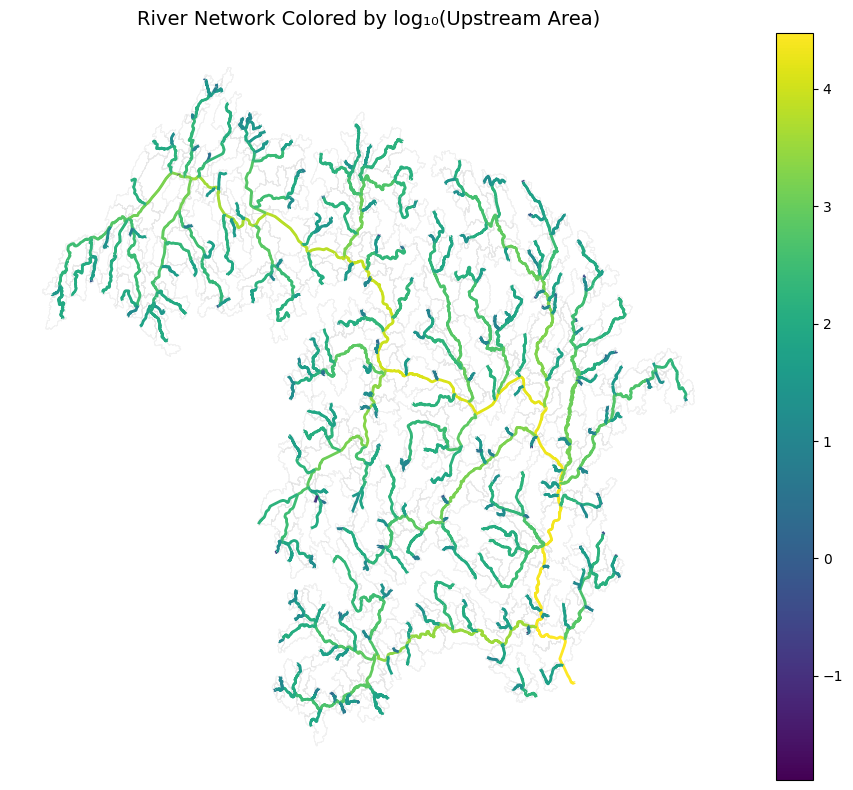

In [6]:
# --------------------------------------------------
# Load river network and catchment
# --------------------------------------------------
riv = gpd.read_file(riv_file)
cat = gpd.read_file(cat_file)

# --------------------------------------------------
# 1. Clean the river network or subbasins
# --------------------------------------------------
# keep the grid_code that is shared between the riv and cat
# grid_codes shared between riv and cat
grid_codes = (set(riv["grid_code"].astype(int)) & set(cat["gridcode"].astype(int)))
riv = riv[riv["grid_code"].isin(grid_codes)].sort_values("grid_code").reset_index(drop=True)
cat = cat[cat["gridcode"].isin(grid_codes)].sort_values("gridcode").reset_index(drop=True)

# --------------------------------------------------
# 2. Create the Next Down COMID
# --------------------------------------------------
# Expected columns:
# - grid_code
# - from_node
# - to_node
# --------------------------------------------------
# Build mapping: from_node → grid_code
# --------------------------------------------------
fromnode_to_grid = dict(
    zip(riv["from_node"], riv["grid_code"])
)
# --------------------------------------------------
# Assign downstream grid_code
# --------------------------------------------------
riv["NextDownGridCode"] = riv["to_node"].map(fromnode_to_grid)
# --------------------------------------------------
# Handle outlets (no downstream segment)
# --------------------------------------------------
riv["NextDownGridCode"] = (
    riv["NextDownGridCode"]
    .fillna(-9999)
    .astype(int)
)
# --------------------------------------------------
# Optional: quick sanity check
# --------------------------------------------------
n_outlets = (riv["NextDownGridCode"] == -9999).sum()
print(f"Number of outlet segments: {n_outlets}")


# --------------------------------------------------
# 3. Compute upstream area
# --------------------------------------------------
cat["Shape_Areakm2"] = cat["Shape_Area"].fillna(0.0)*(10**-6)
riv["Shape_Areakm2"] = cat["Shape_Areakm2"].fillna(0.0)
riv = Utility.compute_uparea(
    riv,
    comid_col="grid_code",
    next_col="NextDownGridCode",
    area_col="Shape_Areakm2",
    out_col="uparea",
)

# --------------------------------------------------
# 4. Reprojection for WGS 84 (latitude / longitude)
# --------------------------------------------------
target_crs = "EPSG:4326"
# Reproject river network
if riv.crs is None:
    raise ValueError("riv has no CRS defined. Set riv.crs before reprojecting.")
riv = riv.to_crs(target_crs)
# Reproject catchments
if cat.crs is None:
    raise ValueError("cat has no CRS defined. Set cat.crs before reprojecting.")
cat = cat.to_crs(target_crs)

# --------------------------------------------------
# 5. Plot rivers colored by upstream area
# --------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

riv.assign(log_uparea=np.log10(riv["uparea"].where(riv["uparea"] > 0))).plot(
    column="log_uparea",
    ax=ax,
    legend=True,
    linewidth=2.0,
    cmap="viridis",
    missing_kwds={"color": "lightgrey", "label": "Zero / NA"},
)

# Plot subbasins (cat) first as faint transparent outlines
cat.plot(
    ax=ax,
    facecolor="none",       # no fill
    edgecolor="lightgrey",  # faint edges
    linewidth=0.5,
    alpha=0.3
)

ax.set_title("River Network Colored by log₁₀(Upstream Area)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [4]:
#load hydrolakeDataset
lakeO = gpd.read_file(lake_file) # read the hydrolake dataset

# create the folder if not existed
org_folder = os.path.join(OutFolder, "org")
if os.path.isdir(org_folder):
    try:
        shutil.rmtree(org_folder)
    except OSError as e:
        raise RuntimeError(f"Failed to remove {org_folder}: {e}")
os.makedirs(org_folder, exist_ok=True)

# save riv and cat
riv.to_file(os.path.join(org_folder, "riv.gpkg"))
cat.to_file(os.path.join(org_folder, "cat.gpkg"))

# create the folder if not existed
corrected_folder = os.path.join(OutFolder, "corrected")
if os.path.isdir(corrected_folder):
    try:
        shutil.rmtree(corrected_folder)
    except OSError as e:
        raise RuntimeError(f"Failed to remove {corrected_folder}: {e}")
os.makedirs(corrected_folder, exist_ok=True)

# create the config and pass it to the Burn lake
config = {
    "riv": riv,
    "riv_dict": {
        "COMID": {"col":"grid_code"},
        "NextDownCOMID": {"col":"NextDownGridCode"},
        "length": {"col":"Shape_Leng"},
        "uparea": {"col":"uparea","unit":"km2"}
    },
    "cat": cat,
    "cat_dict": {
        "COMID": {"col":"gridcode"},
        "unitarea": {"col":"Shape_Areakm2","unit":"km2"},
    },
    "lake": lakeO,
    "lake_dict": {
        "LakeCOMID": {"col":"Hylak_id"},
        "unitarea": {"col":"Lake_area","unit":"km2"}
    },
}

bl = BurnLakes(config)
bl.riv.to_file(os.path.join(corrected_folder, "riv.gpkg"))
bl.cat.to_file(os.path.join(corrected_folder, "cat.gpkg"))
bl.lake.to_file(os.path.join(corrected_folder, "lake.gpkg"))

=== Input loader started at : 2025-12-19 20:23:22  ===
riv: Loaded
riv_dict: {'COMID': {'col': 'grid_code'}, 'NextDownCOMID': {'col': 'NextDownGridCode'}, 'length': {'col': 'Shape_Leng'}, 'uparea': {'col': 'uparea', 'unit': 'km2'}}
cat: Loaded
cat_dict: {'COMID': {'col': 'gridcode'}, 'unitarea': {'col': 'Shape_Areakm2', 'unit': 'km2'}}
lake: Loaded
lake_dict: {'LakeCOMID': {'col': 'Hylak_id'}, 'unitarea': {'col': 'Lake_area', 'unit': 'km2'}}
=== Input loader finished at: 2025-12-19 20:23:22  ===
=== Input loader took      : 0:00:00.406160  ===========================
=== Input checker started at : 2025-12-19 20:23:22  ===
Subbasin and lake area units are consistent: km2
riv CRS: EPSG:4326
cat CRS: EPSG:4326
lake CRS: EPSG:4326
=== Input checker finished at: 2025-12-19 20:23:23  ===
=== Input checker took      : 0:00:00.544565  ===========================
=== Resolving lakes started at : 2025-12-19 20:23:23  ===
==== Number of lakes after subsetting: 2738 ====
==== Number of lakes after

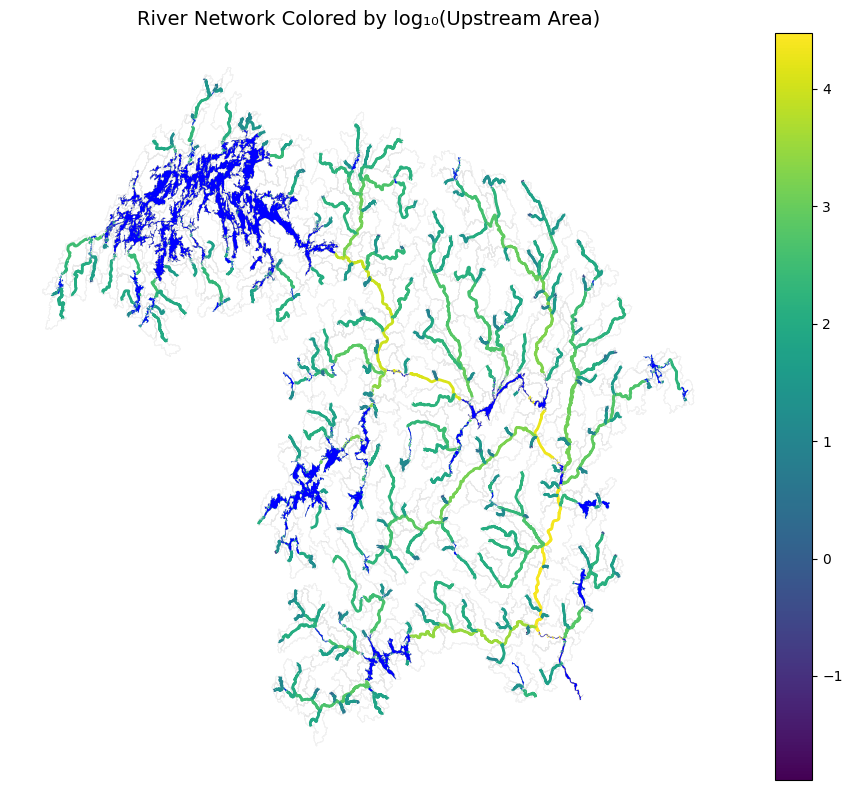

In [10]:
# --------------------------------------------------
# Plot rivers colored by upstream area
# --------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot subbasins (cat) first as faint transparent outlines
bl.cat.plot(
    ax=ax,
    facecolor="none",       # no fill
    edgecolor="lightgrey",  # faint edges
    linewidth=0.5,
    alpha=0.3
)

# Plot rivers on top, colored by log10(upstream area)
bl.riv.assign(log_uparea=np.log10(bl.riv["uparea"].where(bl.riv["uparea"] > 0))).plot(
    column="log_uparea",
    ax=ax,
    legend=True,
    linewidth=2.0,
    cmap="viridis",
    missing_kwds={"color": "lightgrey", "label": "Zero / NA"},
)

# Plot lakes
bl.lake.plot(
    ax=ax,
    facecolor="blue",  # blue fill
    edgecolor="none",  # faint edges
    linewidth=0.5,
)

ax.set_title("River and Lake Network Colored by log₁₀(Upstream Area)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()
